# Simulated Annealing

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using simulated annealing

__SIMULATED-ANNEALING__(_source_ , _destination_ , _schedule_ , _num of iterations_ ) __returns__ a route  
&emsp;_current_ &larr; random-route between _source_ and _destination_  
&emsp;__for__ _num of iterations_ __do__    
&emsp;&emsp; _T_ &larr; _schedule(t)_  
&emsp;&emsp; _neighbors_ &larr; _current_.NEIGHBOURS  
&emsp;&emsp; _next_ &larr; randomly choose one state from _neighbors_  
&emsp;&emsp; _$\Delta$_ _E_ &larr; _next_._COST_ - _current_._COST_  
&emsp;&emsp; __if__ _$\Delta$_ _E_ &lt; 0 __then__ _current_ &larr; _next_    
&emsp;&emsp; __else__ _current_ &larr; _next_ only with probability of ${e}^{-\frac{\Delta E}{T}}$  
&emsp;__endfor__  
&emsp; _route_ &larr; _current_  
&emsp; __return__ _route_

In [1]:
import osmnx as ox
import time, itertools
from tqdm import tqdm
from utilities import *

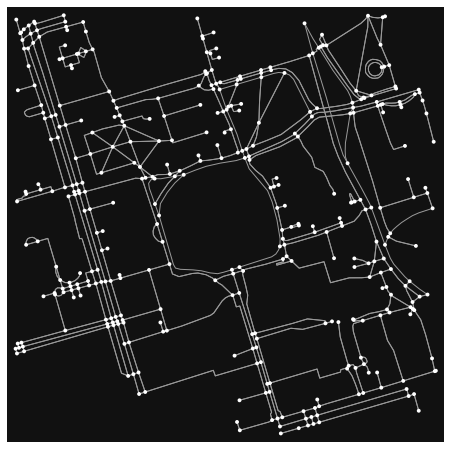

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
fig, ax = ox.plot_graph(G)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

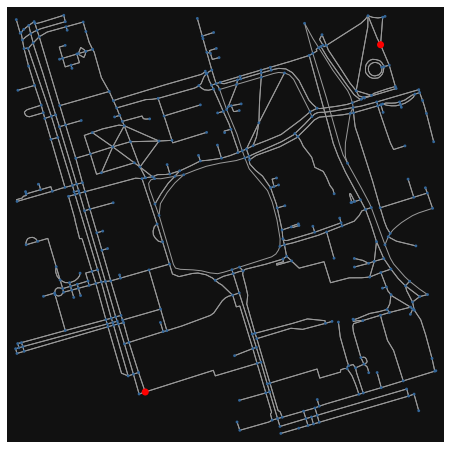

In [3]:
highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [4]:
draw_map(G, highlight = highlighted)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [5]:
%%capture
source(Node)

We need to generate a random paths from source and destination to be the starting state in simulated annealing. The following algorithm is just a variant of the typical graph search but instead of choosing the node to be expanded based on a certain policy like bfs/dfs, we just choose the node randomly from the frontier.

In [6]:
source(randomized_search)

The default of the schedule function is that the initial temperature is 20 and it gets terminated after 100 unit time.

In [7]:
source(exp_schedule)

In [8]:
schedule = exp_schedule(200, 0.05, 10000)

This will take about 10 minutes to run, because generating children for a route is a bit computationally expensive.

In [15]:
num_of_iterations = 40

In [10]:
%%time
states = []
current = randomized_search(G, 55808290, 389677909)

for t in tqdm(range(num_of_iterations)):
    T = schedule(t)
    states.append(cost(G, current))
    
    # generate 5 more paths to choose from
    neighbors = [*itertools.islice(children_route(G, current), 100)]
    next_choice = random.choice(neighbors)
    
    delta_e = cost(G, next_choice) - cost(G, current)  
    if delta_e < 0 or probability(np.exp(-1 * delta_e/T)):
        current = next_choice
        
route = current

  1%|          | 1/100 [00:08<14:28,  8.77s/it]

1109.076


  2%|▏         | 2/100 [00:17<14:19,  8.77s/it]

1095.902


  3%|▎         | 3/100 [00:25<13:55,  8.61s/it]

1095.902


  4%|▍         | 4/100 [00:34<13:47,  8.62s/it]

1141.5690000000002


  5%|▌         | 5/100 [00:46<15:17,  9.66s/it]

1026.005


  6%|▌         | 6/100 [00:57<15:39,  9.99s/it]

870.084


  7%|▋         | 7/100 [01:09<16:40, 10.76s/it]

870.084


  8%|▊         | 8/100 [01:22<17:12, 11.22s/it]

870.084


  9%|▉         | 9/100 [01:35<18:05, 11.93s/it]

887.1619999999999


 10%|█         | 10/100 [01:46<17:15, 11.50s/it]

887.1619999999999


 11%|█         | 11/100 [01:57<16:51, 11.36s/it]

899.83


 12%|█▏        | 12/100 [02:07<16:19, 11.13s/it]

1034.946


 13%|█▎        | 13/100 [02:19<16:16, 11.22s/it]

1034.946


 14%|█▍        | 14/100 [02:30<16:09, 11.27s/it]

1034.946


 15%|█▌        | 15/100 [02:42<16:00, 11.30s/it]

1051.527


 16%|█▌        | 16/100 [02:52<15:17, 10.92s/it]

1051.527


 17%|█▋        | 17/100 [03:02<14:48, 10.70s/it]

1051.527


 18%|█▊        | 18/100 [03:11<14:07, 10.33s/it]

1064.195


 19%|█▉        | 19/100 [03:20<13:18,  9.86s/it]

1064.195


 20%|██        | 20/100 [03:29<12:40,  9.50s/it]

1064.195


 21%|██        | 21/100 [03:38<12:26,  9.45s/it]

1222.1219999999998


 22%|██▏       | 22/100 [03:51<13:37, 10.48s/it]

1054.788


 23%|██▎       | 23/100 [04:01<13:24, 10.44s/it]

1054.788


 24%|██▍       | 24/100 [04:12<13:10, 10.40s/it]

1054.788


 25%|██▌       | 25/100 [04:23<13:15, 10.61s/it]

1036.592


 26%|██▌       | 26/100 [04:35<13:53, 11.27s/it]

1036.592


 27%|██▋       | 27/100 [04:49<14:31, 11.94s/it]

889.093


 28%|██▊       | 28/100 [05:03<15:09, 12.64s/it]

889.093


 29%|██▉       | 29/100 [05:18<15:36, 13.19s/it]

901.703


 30%|███       | 30/100 [05:31<15:29, 13.28s/it]

937.516


 31%|███       | 31/100 [05:42<14:33, 12.67s/it]

962.139


 32%|███▏      | 32/100 [05:52<13:26, 11.86s/it]

962.139


 33%|███▎      | 33/100 [06:02<12:28, 11.17s/it]

927.1520000000002


 34%|███▍      | 34/100 [06:15<12:48, 11.64s/it]

927.1520000000002


 35%|███▌      | 35/100 [06:27<12:43, 11.74s/it]

927.768


 36%|███▌      | 36/100 [06:34<11:10, 10.48s/it]

911.787


 37%|███▋      | 37/100 [06:42<10:14,  9.76s/it]

838.502


 38%|███▊      | 38/100 [06:51<09:37,  9.32s/it]

838.502


 39%|███▉      | 39/100 [06:59<09:09,  9.00s/it]

838.502


 40%|████      | 40/100 [07:07<08:49,  8.82s/it]

838.502


 41%|████      | 41/100 [07:16<08:34,  8.73s/it]

838.502


 42%|████▏     | 42/100 [07:24<08:26,  8.74s/it]

838.502


 43%|████▎     | 43/100 [07:33<08:20,  8.78s/it]

838.502


 44%|████▍     | 44/100 [07:42<08:11,  8.78s/it]

838.502


 45%|████▌     | 45/100 [07:51<08:10,  8.92s/it]

838.502


 46%|████▌     | 46/100 [08:03<08:42,  9.68s/it]

838.502


 47%|████▋     | 47/100 [08:15<09:11, 10.40s/it]

838.502


 48%|████▊     | 48/100 [08:25<09:03, 10.45s/it]

838.502


 49%|████▉     | 49/100 [08:35<08:39, 10.18s/it]

838.502


 50%|█████     | 50/100 [08:44<08:12,  9.85s/it]

838.502


 51%|█████     | 51/100 [08:53<07:47,  9.54s/it]

838.502


 52%|█████▏    | 52/100 [09:02<07:28,  9.34s/it]

838.502


 53%|█████▎    | 53/100 [09:11<07:21,  9.40s/it]

838.502


 54%|█████▍    | 54/100 [09:22<07:24,  9.67s/it]

838.502


 55%|█████▌    | 55/100 [09:33<07:31, 10.04s/it]

838.502


 56%|█████▌    | 56/100 [09:44<07:46, 10.61s/it]

838.502


 57%|█████▋    | 57/100 [09:57<07:59, 11.15s/it]

838.502


 58%|█████▊    | 58/100 [10:10<08:10, 11.68s/it]

838.502


 59%|█████▉    | 59/100 [10:22<08:11, 11.99s/it]

838.502


 60%|██████    | 60/100 [10:33<07:47, 11.68s/it]

838.502


 61%|██████    | 61/100 [10:45<07:31, 11.58s/it]

838.502


 62%|██████▏   | 62/100 [10:57<07:21, 11.63s/it]

838.502


 63%|██████▎   | 63/100 [11:07<07:02, 11.42s/it]

838.502


 64%|██████▍   | 64/100 [11:18<06:37, 11.04s/it]

838.502


 65%|██████▌   | 65/100 [11:28<06:17, 10.80s/it]

838.502


 66%|██████▌   | 66/100 [11:39<06:14, 11.03s/it]

838.502


 67%|██████▋   | 67/100 [11:52<06:17, 11.44s/it]

844.03


 68%|██████▊   | 68/100 [12:03<06:06, 11.44s/it]

844.03


 69%|██████▉   | 69/100 [12:14<05:48, 11.24s/it]

844.03


 70%|███████   | 70/100 [12:24<05:25, 10.87s/it]

844.03


 71%|███████   | 71/100 [12:34<05:06, 10.57s/it]

844.03


 72%|███████▏  | 72/100 [12:44<04:54, 10.53s/it]

844.03


 73%|███████▎  | 73/100 [12:55<04:44, 10.55s/it]

844.03


 74%|███████▍  | 74/100 [13:06<04:36, 10.62s/it]

844.03


 75%|███████▌  | 75/100 [13:16<04:25, 10.64s/it]

844.03


 76%|███████▌  | 76/100 [13:26<04:10, 10.45s/it]

844.03


 77%|███████▋  | 77/100 [13:36<03:55, 10.25s/it]

844.03


 78%|███████▊  | 78/100 [13:46<03:41, 10.05s/it]

844.03


 79%|███████▉  | 79/100 [13:55<03:27,  9.89s/it]

844.03


 80%|████████  | 80/100 [14:05<03:13,  9.70s/it]

844.03


 81%|████████  | 81/100 [14:14<03:01,  9.53s/it]

837.063


 82%|████████▏ | 82/100 [14:26<03:05, 10.32s/it]

830.458


 83%|████████▎ | 83/100 [14:36<02:54, 10.26s/it]

830.458


 84%|████████▍ | 84/100 [14:47<02:47, 10.49s/it]

830.458


 85%|████████▌ | 85/100 [14:59<02:44, 10.94s/it]

830.458


 86%|████████▌ | 86/100 [15:11<02:37, 11.26s/it]

830.458


 87%|████████▋ | 87/100 [15:23<02:29, 11.52s/it]

830.458


 88%|████████▊ | 88/100 [15:35<02:19, 11.59s/it]

830.458


 89%|████████▉ | 89/100 [15:47<02:08, 11.68s/it]

830.458


 90%|█████████ | 90/100 [15:58<01:55, 11.60s/it]

830.458


 91%|█████████ | 91/100 [16:10<01:44, 11.56s/it]

830.458


 92%|█████████▏| 92/100 [16:21<01:31, 11.44s/it]

830.458


 93%|█████████▎| 93/100 [16:30<01:15, 10.84s/it]

830.458


 94%|█████████▍| 94/100 [16:39<01:00, 10.14s/it]

830.458


 95%|█████████▌| 95/100 [16:47<00:47,  9.57s/it]

830.458


 96%|█████████▌| 96/100 [16:55<00:36,  9.11s/it]

830.458


 97%|█████████▋| 97/100 [17:03<00:26,  8.79s/it]

830.458


 98%|█████████▊| 98/100 [17:11<00:17,  8.55s/it]

830.458


 99%|█████████▉| 99/100 [17:19<00:08,  8.40s/it]

830.458


100%|██████████| 100/100 [17:27<00:00, 10.48s/it]

830.458
CPU times: user 17min 21s, sys: 2.95 s, total: 17min 24s
Wall time: 17min 27s


In [11]:
cost(G, route)

830.458

Remember that the optimal cost for the route is 801.4639999999999  

You should get 830-ish as the cost of the route between source and destination without any tuning of the schedule function.

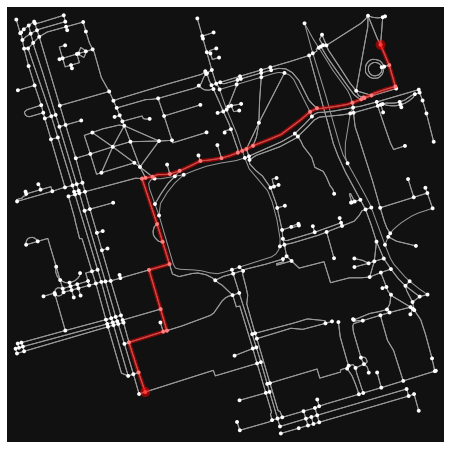

In [12]:
fig, ax = ox.plot_graph_route(G, current)

In [13]:
draw_route(G, route)

Map(center=[43.6618621, -79.3941032], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

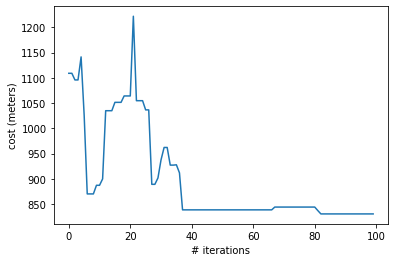

In [14]:
import matplotlib.pyplot as plt
plt.xlabel("# iterations")
plt.ylabel("cost (meters)")
plt.plot(states)
plt.show()